<a href="https://colab.research.google.com/github/Jeonghwan-Cheon/Predict-Tocitity-of-Chemical-Compound/blob/master/Predict_Toxicity_of_Chemical_Compounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Toxicity of Chemical Compounds


> 2020 Fall Semester Bioinformatics  
Project #5  
Jeonghwan Cheon (20190643)  





### Project Goal
* Predict the toxicity of compounds using a neural network model 
* Datasets: 'nr-ar.smiles' and 'nr-er.smiles' file. 
* Each file contains 'smiles string of compound', 'array data', and 'activity value' 
* Activity value is marked as 0 when a compound is non-toxic, and 1 vice versa. 


> Mayr, Andreas, et al. "DeepTox: toxicity prediction using deep learning." Frontiers in Environmental Science 3 (2016): 80.







### Guideline for Project

1. Build a neural network model for predicting the toxicity of compounds.
2. Randomly split the dataset to training set and test set using train_test_split from sklearn (8:2)
3. Train your model using the training dataset (and optimize your model using validation set).
4. Report the ROC-AUC score of the test dataset using the trained model. (https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)
5. Use google colab (or whatever you want)
6. Upload ".ipynb" file or link to your google colab code 



# Setup Environment

In [ ]:
# install rdkit library on colab environment
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [ ]:
# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

#import basic python packages
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase

import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.backend import one_hot
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils

In [ ]:
# load data from google drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
address = '/gdrive/My Drive/Development Project/Predict Toxicity of Chemical Compounds/'
data_AR = address+'nr-ar.smiles'
data_ER = address+'nr-er.smiles'

Mounted at /gdrive


# Dataset Processing

In [ ]:
# save the uploaded data as Pandas dataframe
import io
df_AR = pd.read_csv(data_AR, sep = '\t', names = ['smiles', 'array', 'activity'])
df_ER = pd.read_csv(data_ER, sep = '\t', names = ['smiles', 'array', 'activity'])

smi_AR = df_AR['smiles']
smi_ER = df_ER['smiles']
activity_AR = df_AR['activity']
activity_ER = df_ER['activity']

# print the head of dataset
print("---------- smiles data of AR ----------")
print(smi_AR.head())
print("\n---------- activity data of AR ----------")
print(activity_AR.head())
print("\n---------- smiles data of ER ----------")
print(smi_ER.head())
print("\n---------- activity data of AR ----------")
print(activity_ER.head())

---------- smiles data of AR ----------
0    CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...
1      Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2
2    Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...
3    Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...
4           [Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1
Name: smiles, dtype: object

---------- activity data of AR ----------
0    0
1    0
2    0
3    0
4    0
Name: activity, dtype: int64

---------- smiles data of ER ----------
0    Cl.[H][C@@]1(CCCCN1)[C@@H](O)C2=CC(=NC3=C2C=CC...
1    COC1=CC=C2[C@H]([C@H](C3=CC=CC=C3)C(C)(C)OC2=C...
2              NC1=NC(N)=C2N=C(C3=CC=CC=C3)C(N)=NC2=N1
3    CC1(C)CNC(NC1)=NN=C(\C=C\C2=CC=C(C=C2)C(F)(F)F...
4    [Cl-].CCCCCCCCCC[N+](C)(CCCCCCCCCC)CCC[Si](OC)...
Name: smiles, dtype: object

---------- activity data of AR ----------
0    1
1    0
2    0
3    1
4    0
Name: activity, dtype: int64


In [ ]:
# data preprocessing; convert SMILES string to 2048 bit Fingerprint
def preprocessing(data_X, data_Y):
  data_x = []
  data_y = []

  if len(data_X)==len(data_Y):
    length = len(data_X)
  else :
    print("Error: two input data have different size")

  lossDataCount = 0

  for i in range(length):
    mol = Chem.MolFromSmiles(data_X[i])
    if mol != None:
      # Smiles data process
      fp = Chem.RDKFingerprint(mol)
      data_x.append(list(map(int, fp.ToBitString())))
      # Activaty data process ([activation, inactivation])
      if data_Y[i] == 1:
        data_y.append([1, 0])
      else:
        data_y.append([0, 1])
    else:
      lossDataCount += 1;

  print("Total ", lossDataCount, "data deleted")

  return np.array(data_x), np.array(data_y)

data_X_AR, data_Y_AR = preprocessing(smi_AR, activity_AR)
data_X_ER, data_Y_ER = preprocessing(smi_ER, activity_ER)

Total  3 data deleted
Total  2 data deleted


Since some of the smiles data cannot be converted to fingerprint, those data were deleted. In AR dataset, 3 data deleted. In ER dataset, 2 data deleted.

In [ ]:
# check the shape of the raw data
print("data_X_AR: ", data_X_AR.shape)
print("data_Y_AR: ", data_Y_AR.shape)
print("data_X_ER: ", data_X_ER.shape)
print("data_Y_ER: ", data_Y_ER.shape)

data_X_AR:  (9359, 2048)
data_Y_AR:  (9359, 2)
data_X_ER:  (7695, 2048)
data_Y_ER:  (7695, 2)


In [ ]:
def count_activation(data_Y):
  activationCount = 0
  inactivationCount = 0
  for i in range(len(data_Y)):
    if data_Y[i][0] == 1:
      activationCount += 1
    elif data_Y[i][1] == 1:
      inactivationCount += 1
  print("Activation : ", activationCount, "Inactivation : ", inactivationCount)
  return activationCount, inactivationCount

print("AR")
AR_activation, AR_inactivation = count_activation(data_Y_AR)
print("ER")
ER_activation, ER_inactivation = count_activation(data_Y_ER)

AR
Activation :  380 Inactivation :  8979
ER
Activation :  937 Inactivation :  6758


In [ ]:
# split the training, validation and test dataset. train:validation:test=8:1:1
from sklearn.model_selection import train_test_split

#split training and test dataset from raw dataset
X_temp_AR, X_test_AR, Y_temp_AR, Y_test_AR = train_test_split(data_X_AR, data_Y_AR, test_size=0.1, shuffle=True, stratify=data_Y_AR, random_state=10)
X_temp_ER, X_test_ER, Y_temp_ER, Y_test_ER = train_test_split(data_X_ER, data_Y_ER, test_size=0.1, shuffle=True, stratify=data_Y_ER, random_state=10)

#split training and validation dataset from training dataset
X_train_AR, X_valid_AR, Y_train_AR, Y_valid_AR = train_test_split(X_temp_AR, Y_temp_AR, test_size=0.111, shuffle=True, stratify=Y_temp_AR, random_state=1)
X_train_ER, X_valid_ER, Y_train_ER, Y_valid_ER = train_test_split(X_temp_ER, Y_temp_ER, test_size=0.111, shuffle=True, stratify=Y_temp_ER, random_state=1)

In [ ]:
# check the shape of the splited data
print("X_train_AR: ", X_train_AR.shape, "Y_train_AR: ", Y_train_AR.shape)
print("X_valid_AR: ", X_valid_AR.shape, "Y_valid_AR: ", Y_valid_AR.shape)
print("X_test_AR: ", X_test_AR.shape, "Y_test_AR: ", Y_test_AR.shape)
print("X_train_ER: ", X_train_ER.shape, "Y_train_ER: ", Y_train_ER.shape)
print("X_valid_ER: ", X_valid_ER.shape, "Y_valid_ER: ", Y_valid_ER.shape)
print("X_test_ER: ", X_test_ER.shape, "Y_test_ER: ", Y_test_ER.shape)

print("\n<Final Splited Dataset Ratio>")
print("AR Dataset : train(%.02f %%), valid(%.02f %%), test(%.02f %%)" %(float(len(X_train_AR)*100/(len(X_train_AR)+len(X_valid_AR)+len(X_test_AR))),
                                                                           float(len(X_valid_AR)*100/(len(X_train_AR)+len(X_valid_AR)+len(X_test_AR))),
                                                                           float(len(X_test_AR)*100/(len(X_train_AR)+len(X_valid_AR)+len(X_test_AR)))))
print("ER Dataset : train(%.02f %%), valid(%.02f %%), test(%.02f %%)" %(float(len(X_train_ER)*100/(len(X_train_ER)+len(X_valid_ER)+len(X_test_ER))),
                                                                           float(len(X_valid_ER)*100/(len(X_train_ER)+len(X_valid_ER)+len(X_test_ER))),
                                                                           float(len(X_test_ER)*100/(len(X_train_ER)+len(X_valid_ER)+len(X_test_ER)))))

X_train_AR:  (7488, 2048) Y_train_AR:  (7488, 2)
X_valid_AR:  (935, 2048) Y_valid_AR:  (935, 2)
X_test_AR:  (936, 2048) Y_test_AR:  (936, 2)
X_train_ER:  (6156, 2048) Y_train_ER:  (6156, 2)
X_valid_ER:  (769, 2048) Y_valid_ER:  (769, 2)
X_test_ER:  (770, 2048) Y_test_ER:  (770, 2)

<Final Splited Dataset Ratio>
AR Dataset : train(80.01 %), valid(9.99 %), test(10.00 %)
ER Dataset : train(80.00 %), valid(9.99 %), test(10.01 %)


# Building Deep Neural Network (DNN)

In [ ]:
# build a neural network model
# the activation function of hidden layer is relu, and output is softmax

def build_model():
  # add layers to build a model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=1024, input_dim=2048, activation='relu'), )
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=512, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-6)))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=64, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-5))) 
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units=2, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add(tf.keras.layers.Softmax(name="softmax"))
  # compile and return model
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.AUC(name='auc')])
  return model

# make a prediction model for AR
model_AR = build_model()
model_AR.summary() # print summary of AR model

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_361 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_242 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_362 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_243 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_363 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_244 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_364 (Dense)            (None, 2)              

In [ ]:
# make a predictin model for ER
model_ER = build_model()
model_ER.summary()# print summary of ER model

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_365 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_245 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_366 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_246 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_367 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_247 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_368 (Dense)            (None, 2)              

In [ ]:
# early stopping with validation dataset 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)
es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# setting class_weight to solve inbalanced dataset problem
print("AR activation: ", AR_activation/(AR_activation+AR_inactivation), "AR inactivation: ", AR_inactivation/(AR_activation+AR_inactivation))
print("ER activation: ", ER_activation/(ER_activation+ER_inactivation), "ER inactivation: ", ER_inactivation/(ER_activation+ER_inactivation))

class_weight_AR = {0: 0.65, 1 : 0.45}
class_weight_ER = {0: 0.60, 1 : 0.40}

AR activation:  0.04060262848594935 AR inactivation:  0.9593973715140507
ER activation:  0.12176738141650423 ER inactivation:  0.8782326185834958


To solve inbalanced dataset problem, I tried to weight specific ratios for class_weight. Since activation data is much more than inactivation data, I tired to multiply larger number to activation data to make balance. At first, I tried to multiply the ratio of activation or inactivation count about total dataset. However, the ratio was so radical that makes AUC score bad. So, I tried several test to find the proper ratio that makes better AUC score. As the result, for AR dataset, I multiplied 0.65 and 0.45 for each class_weight. For ER dataset, I multiplied 0.6 and 0.40 for each class_weight.

In [ ]:
# training the model using training and validation set
epochs = 100

hist_AR = model_AR.fit(X_train_AR, Y_train_AR, validation_data=(X_valid_AR, Y_valid_AR), batch_size=32, epochs=epochs, verbose=1, callbacks=[es_AR, mc_AR], class_weight=class_weight_AR)
hist_ER = model_ER.fit(X_train_ER, Y_train_ER, validation_data=(X_valid_ER, Y_valid_ER),batch_size=32, epochs=epochs, verbose=1, callbacks=[es_ER, mc_ER], class_weight=class_weight_ER)

Epoch 1/100
220/234 [===========================>..] - ETA: 0s - loss: 0.1847 - auc: 0.9453
Epoch 00001: val_auc improved from -inf to 0.96931, saving model to best_model_AR.h5
234/234 [==============================] - 1s 5ms/step - loss: 0.1844 - auc: 0.9452 - val_loss: 0.2242 - val_auc: 0.9693
Epoch 2/100
234/234 [==============================] - ETA: 0s - loss: 0.1150 - auc: 0.9720
Epoch 00002: val_auc improved from 0.96931 to 0.97313, saving model to best_model_AR.h5
234/234 [==============================] - 1s 4ms/step - loss: 0.1150 - auc: 0.9720 - val_loss: 0.1706 - val_auc: 0.9731
Epoch 3/100
225/234 [===========================>..] - ETA: 0s - loss: 0.1001 - auc: 0.9762
Epoch 00003: val_auc improved from 0.97313 to 0.97592, saving model to best_model_AR.h5
234/234 [==============================] - 1s 4ms/step - loss: 0.0989 - auc: 0.9767 - val_loss: 0.1473 - val_auc: 0.9759
Epoch 4/100
227/234 [============================>.] - ETA: 0s - loss: 0.0888 - auc: 0.9798
Epoch 00

# Evaluating Model

To solve inbalanced dataset problem, I tried one more method. Rather than using accuracy, I used AUC score to evaluate model. In each step of epoch, calculate the AUC score. Using this index, best model was chosen. When I evaluate model with accuracy, model showed very high accuracy, but it doesn't have ability to detect activited data. Since out datasets have much of activity data, model showed tendency to overfit to activity data. Which means that model often decide 'inactivity data' to any input. This situation makes really high accuracy but it has no meaning. Thus, I changed evaluating method using AUC score.

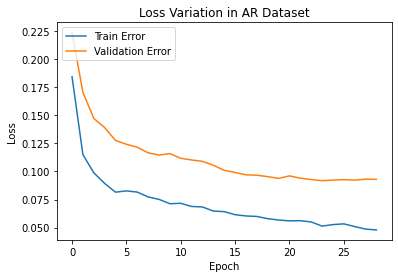

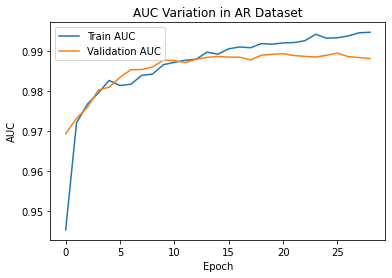

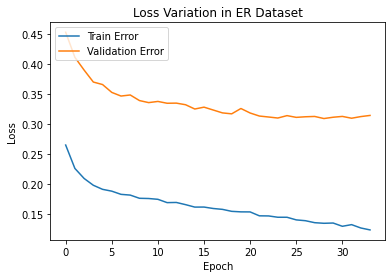

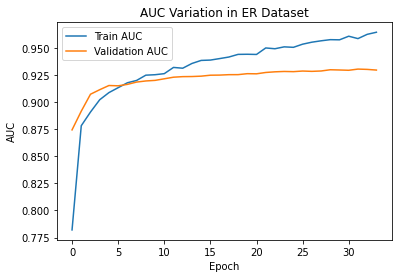

In [ ]:
# plot the accuracy and loss value of each model.
import matplotlib.pyplot as plt

def plot_history(history, name):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Loss Variation in "+name+" Dataset")
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Validation Error')
  plt.legend(loc='upper left')

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.title("AUC Variation in "+name+" Dataset")
  plt.plot(hist['epoch'], hist['auc'],
           label='Train AUC')
  plt.plot(hist['epoch'], hist['val_auc'],
           label = 'Validation AUC')
  plt.legend(loc='upper left')

plot_history(hist_AR, "AR")
plot_history(hist_ER, "ER")

In [ ]:
def toBinary(data):
  temp = []
  for i in range(len(data)):
    if(data[i][0]>data[i][1]): #activation
      temp.append(1)
    else:
      temp.append(0)
  return temp

def toScore(X_test, Y_test, model):
  Y_pred = model.predict(X_test)
  temp = []
  for i in range(len(Y_test)):
    if(Y_test[i][0]>Y_test[i][1]): #activation
      temp.append(Y_pred[i][0])
    else:
      temp.append(Y_pred[i][1])
  return temp

y_true_AR = toBinary(Y_test_AR)
y_pred_AR = toBinary(model_AR.predict(X_test_AR))
y_score_AR = toScore(X_test_AR, Y_test_AR, model_AR)

y_true_ER = toBinary(Y_test_ER)
y_pred_ER = toBinary(model_ER.predict(X_test_ER))
y_score_ER = toScore(X_test_ER, Y_test_ER, model_ER)


<Classification Report>
              precision    recall  f1-score   support

  activation       0.98      1.00      0.99       898
inactivation       0.86      0.63      0.73        38

    accuracy                           0.98       936
   macro avg       0.92      0.81      0.86       936
weighted avg       0.98      0.98      0.98       936

<ROC curve and AUC Score>


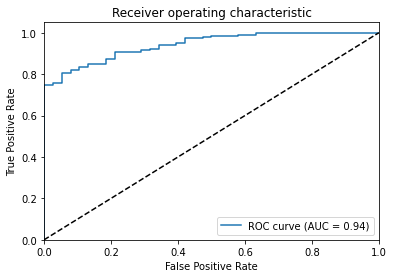

<Confusion Matrix>
TN:  894 FP:  4
FN:  14 TP:  24


In [786]:
# evaluate the prediction model using test dataset.
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
# Run classifier with cross-validation and plot ROC curves
def evaluate_model(y_true, y_pred, y_score):
  target_names = ['activation', 'inactivation']
  print("<Classification Report>")
  print(classification_report(y_true, y_pred, target_names=target_names))

  print("<ROC curve and AUC Score>")
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=0)
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

  matrix = confusion_matrix(y_true, y_pred)
  print("<Confusion Matrix>")
  print("TN: ",matrix[0][0],  "FP: ", matrix[0][1] )
  print("FN: ", matrix[1][0], "TP: ", matrix[1][1])
  return


# AUC of AR dataset
evaluate_model(y_true_AR, y_pred_AR, y_score_AR)

<Classification Report>
              precision    recall  f1-score   support

  activation       0.92      0.97      0.95       676
inactivation       0.67      0.40      0.50        94

    accuracy                           0.90       770
   macro avg       0.79      0.69      0.72       770
weighted avg       0.89      0.90      0.89       770

<ROC curve and AUC Score>


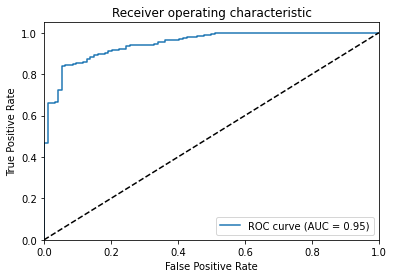

<Confusion Matrix>
TN:  657 FP:  19
FN:  56 TP:  38


In [787]:
# AUC of ER dataset
evaluate_model(y_true_ER, y_pred_ER, y_score_ER)